In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#pip install nrclex
from nrclex import NRCLex
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import datetime
import re
import nltk
from textblob import TextBlob
nltk.download('vader_lexicon')
nltk.download('punkt')  # For tokenization
nltk.download('averaged_perceptron_tagger')# Required for NRCLex
from transformers import pipeline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
df = pd.read_csv('/Users/sheebamoghal/Desktop/courses/DSAN 6000/fall-2024-project-team-35/data/csv/Merged_data.csv', delimiter=',', encoding='utf-8')

df.head(3)

,body,controversiality,created_utc,subreddit
0,I'd like to think I've dealt with cancer head ...,0,1719826058,CancerFamilySupport
1,thank you for pointing out how it’s misunderst...,0,1719799836,CrohnsDisease
2,It made me realise exactly how little I had. A...,0,1719847236,breastcancer


In [28]:
# checking for missing values
df.isna().sum()

body                0
controversiality    0
created_utc         0
subreddit           0
dtype: int64

In [29]:
#for i in df.columns:
#    print(df[i].unique())

print(df['subreddit'].unique())

print(df.dtypes)

# converting the time to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')  # Convert timestamp if necessary

['CancerFamilySupport' 'CrohnsDisease' 'breastcancer' 'thyroidcancer'
 'AskDocs' 'UlcerativeColitis' 'Autoimmune' 'BladderCancer'
 'doihavebreastcancer' 'Lymphedema' 'WomensHealth' 'ProstateCancer' 'cll'
 'Microbiome' 'predental' 'endometrialcancer' 'cancer' 'Hashimotos'
 'coloncancer' 'PreCervicalCancer' 'lymphoma' 'CancerCaregivers'
 'braincancer' 'publichealth' 'nursing' 'testicularcancer' 'lynchsyndrome'
 'HealthInsurance' 'Fuckcancer' 'BRCA' 'Cancersurvivors' 'Health'
 'leukemia' 'pancreaticcancer' 'skincancer' 'stomachcancer']
body                object
controversiality     int64
created_utc          int64
subreddit           object
dtype: object


In [30]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['body'] = df['body'].apply(preprocess_text)

df.head(2)

,body,controversiality,created_utc,subreddit
0,id like to think ive dealt with cancer head on...,0,2024-07-01 09:27:38,CancerFamilySupport
1,thank you for pointing out how its misundersto...,0,2024-07-01 02:10:36,CrohnsDisease


## What is the sentiment distribution across these diverse healthcare subreddits?

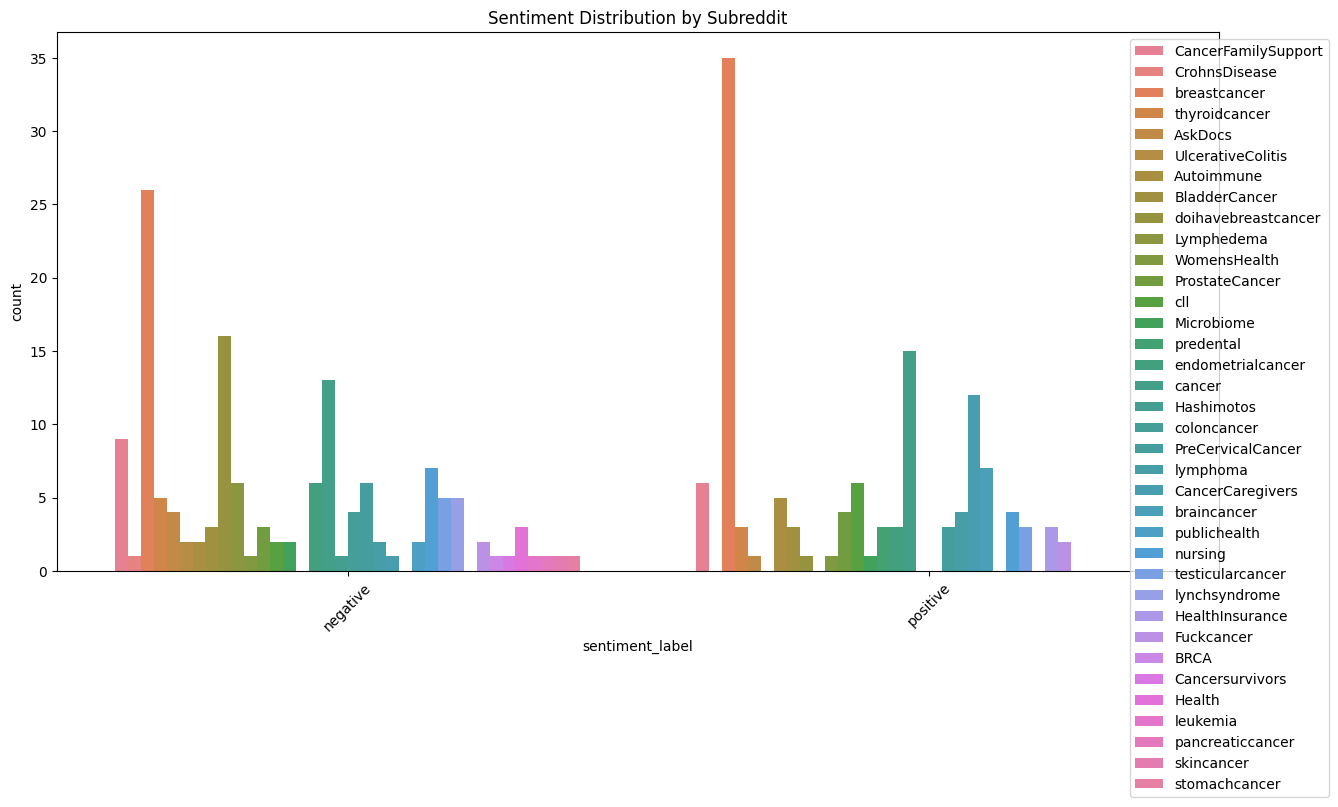

In [ ]:
# Initialize Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['body'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

plt.figure(figsize=(15, 7))
sns.countplot(data=df, x='sentiment_label', hue='subreddit')
plt.title('Sentiment Distribution by Subreddit')
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

## Which emotions are most common in specific healthcare communities?

Used three approaches here.

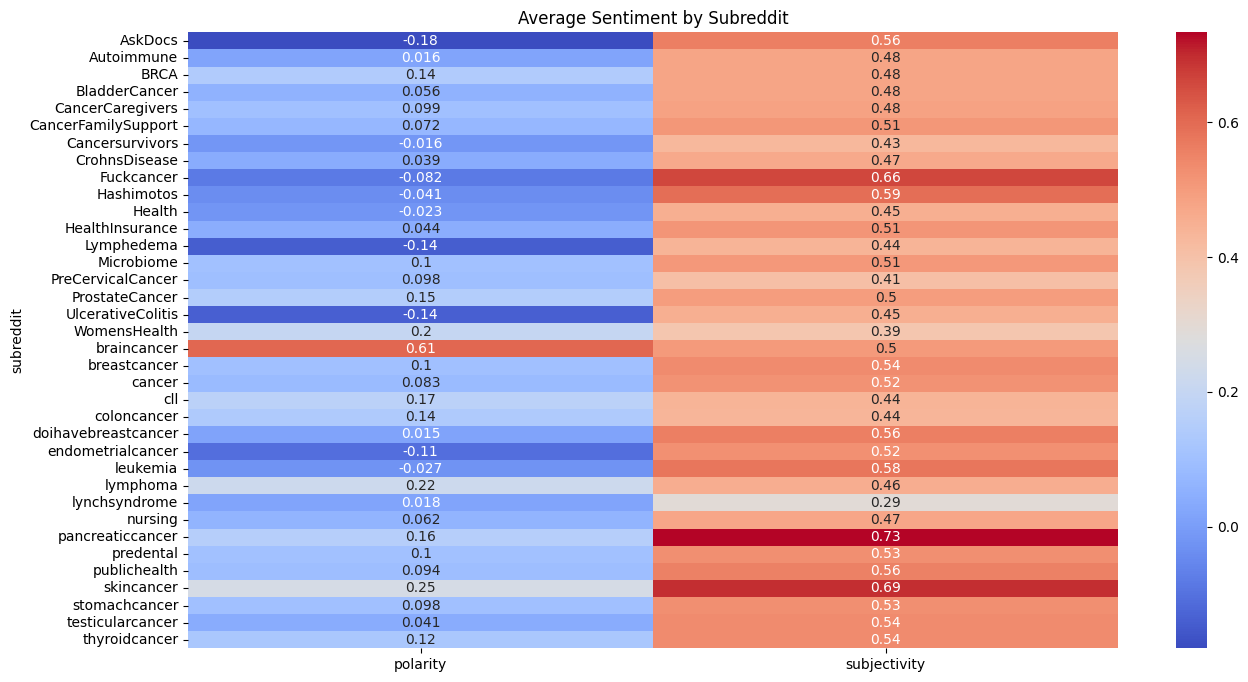

In [ ]:
# using textblob for sentiment analysis as a proxy for emotion

def get_sentiment(text):
    blob = TextBlob(text)
    return {
        'polarity': blob.sentiment.polarity,       # -1 (negative) to 1 (positive)
        'subjectivity': blob.sentiment.subjectivity # 0 (objective) to 1 (subjective)
    }

sentiment_df = pd.DataFrame(df['body'].apply(get_sentiment).tolist())
sentiment_df['subreddit'] = df['subreddit']
sentiment_avg = sentiment_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(sentiment_avg, annot=True, cmap='coolwarm')
plt.title('Average Sentiment by Subreddit')
plt.show()


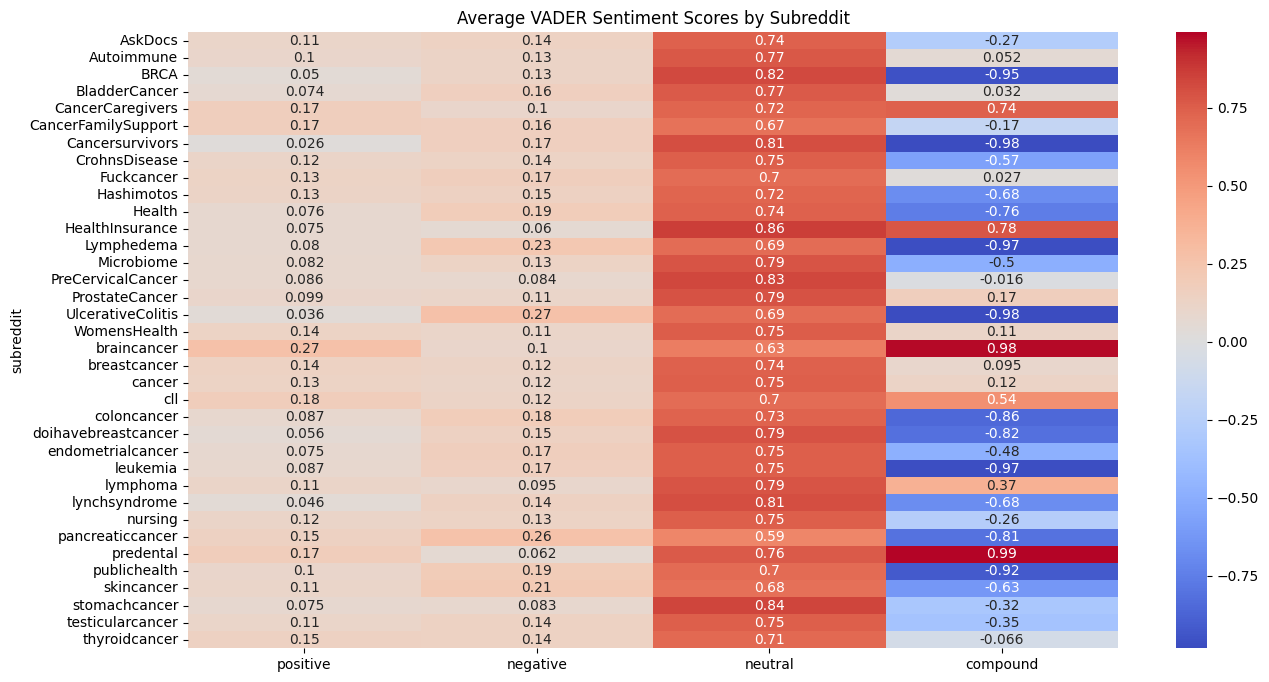

In [ ]:
# using vader for emotional scoring

# VADER
sid = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    scores = sid.polarity_scores(text)
    return {
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu'],
        'compound': scores['compound']
    }

vader_df = pd.DataFrame(df['body'].apply(get_vader_scores).tolist())
vader_df['subreddit'] = df['subreddit']
vader_avg = vader_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(vader_avg, annot=True, cmap='coolwarm')
plt.title('Average VADER Sentiment Scores by Subreddit')
plt.show()


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


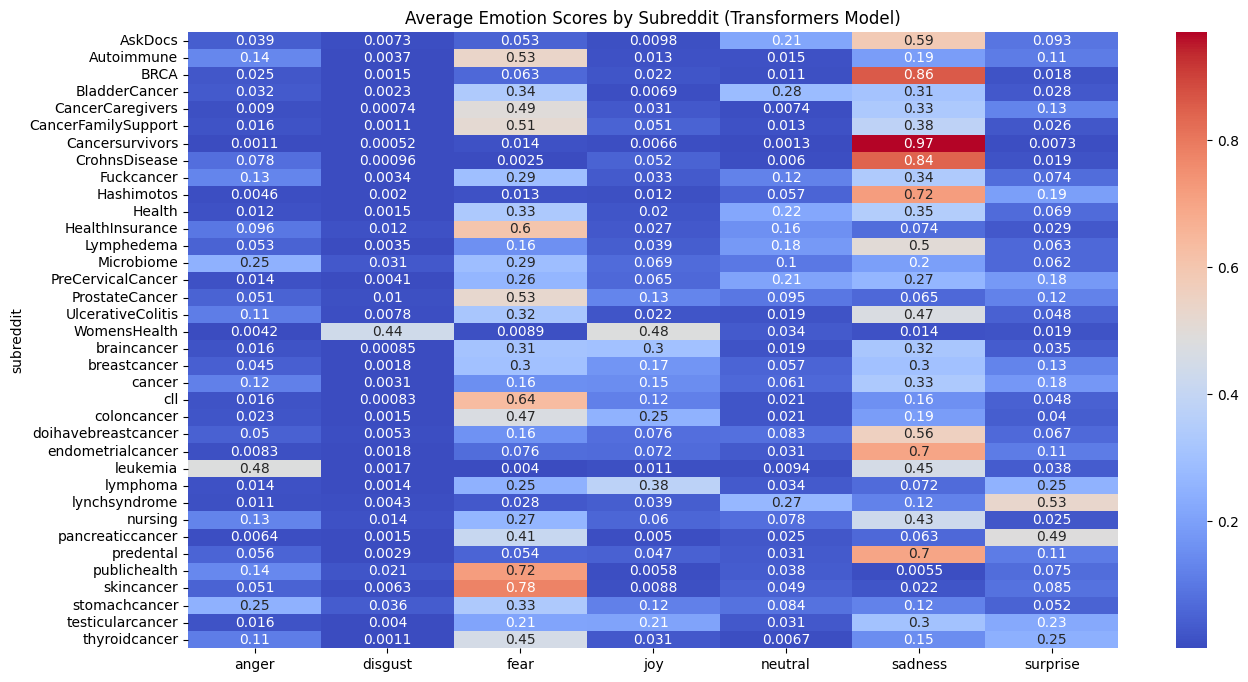

In [ ]:
# using pretained model

MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    tokens = text.split()  # Tokenize by whitespace
    if len(tokens) > max_length:
        text = ' '.join(tokens[:max_length])
    return text

#df['truncated_body'] = df['body'].apply(lambda x: truncate_text(x))

# loading a pretrained emotion classification model
emotion_classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base", 
    return_all_scores=True, 
    truncation=True
)
def get_emotions_transformers(text):
    emotion_scores = emotion_classifier(text)[0]  # Get the list of emotion scores for the text
    # Convert list of scores to a dictionary
    return {item['label']: item['score'] for item in emotion_scores}

emotion_df = pd.DataFrame(df['body'].apply(get_emotions_transformers).tolist())
emotion_df['subreddit'] = df['subreddit']
emotion_avg = emotion_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(emotion_avg, annot=True, cmap='coolwarm')
plt.title('Average Emotion Scores by Subreddit (Transformers Model)')
plt.show()


## What are the primary topics or themes discussed in each subreddit?

In [37]:
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['body'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic 1:
['people', 'able', 'things', 'dont', 'understand', 'prostate', 'radiation', 'medicine', 'like', 'im']
Topic 2:
['need', 'feeling', 'doctors', 'dont', 'lump', 'right', 'people', 'im', 'just', 'did']
Topic 3:
['dont', 'people', 'just', 'like', 'im', 'care', 'things', 'treatment', 'know', 'need']
Topic 4:
['lot', 'pain', 'diagnosed', 'like', 'im', 'just', 'mom', 'know', 'dad', 'time']
Topic 5:
['dont', 'blood', 'life', 'didnt', 'port', 'time', 'body', 'im', 'days', 'chemo']


## Are certain subreddits more likely to express interpersonal conflict or emotional support?

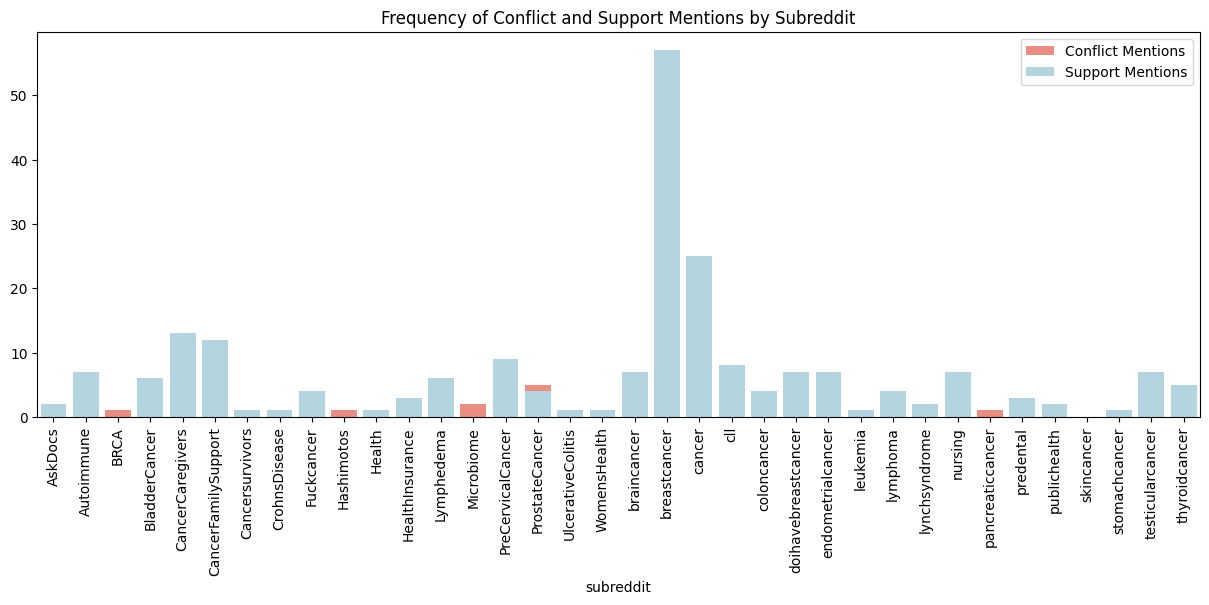

In [42]:
conflict_keywords = [
    "frustration", "disappointment", "anger", "resentment", "annoyance", "conflict", 
    "tension", "irritation", "betrayal", "arguments", "struggle", "stress", 
    "misunderstanding", "criticism", "blame", "guilt", "hostility", "resent", 
    "unhappy", "sadness", "upset", "hurt", "fighting", "argument", "tough", 
    "challenging", "difficulty", "pressure", "discouragement", "despair", 
    "fear", "helplessness", "hopelessness", "loss", "disapproval", "rejection", 
    "grief", "pain", "suffering", "alienation", "abandonment", "desperation", 
    "friction", "dispute", "distrust", "confusion", "embarrassment", "injustice", 
    "unfair", "isolation", "loneliness", "agitation", "disgust", "irritability", 
    "exclusion", "condemnation", "bitterness", "exasperation", "discontent", 
    "jealousy", "envy", "regret", "doubt", "turmoil", "burden", "anxiety", 
    "pressure", "insecurity", "worry", "distress", "disillusionment", "strife", 
    "unresolved", "torment", "persecution", "victimization", "abrasiveness", 
    "defiance", "rebellion", "protest", "contempt", "accusation", "attack", 
    "judgment", "exclusion", "neglect", "withdrawal", "abuse", "mockery", "clash"
]

support_keywords = [
    "support", "help", "care", "encourage", "comfort", "kindness", "understanding", 
    "compassion", "empathy", "assistance", "guidance", "backing", "aid", "uplifting", 
    "positive", "friendship", "community", "reassurance", "sympathy", "solidarity", 
    "together", "listening", "patience", "trust", "love", "appreciation", "encouragement", 
    "advice", "warmth", "respect", "hope", "motivating", "strength", "connection"
]

df['conflict_mention'] = df['body'].apply(lambda x: any(keyword in x for keyword in conflict_keywords))
df['support_mention'] = df['body'].apply(lambda x: any(keyword in x for keyword in support_keywords))

conflict_counts = df.groupby('subreddit')['conflict_mention'].sum()
support_counts = df.groupby('subreddit')['support_mention'].sum()

plt.figure(figsize=(15, 5))
sns.barplot(x=conflict_counts.index, y=conflict_counts.values, color='salmon', label='Conflict Mentions')
sns.barplot(x=support_counts.index, y=support_counts.values, color='lightblue', label='Support Mentions')
plt.title('Frequency of Conflict and Support Mentions by Subreddit')
plt.xticks(rotation=90)
plt.legend()
plt.show()


## How does sentiment vary over time within different healthcare communities?

In [ ]:
print(df['date'].unique()) # so didnt work so can we expand the data? 

[datetime.date(2024, 7, 1)]


## What is the average sentiment score?

<Figure size 1500x800 with 0 Axes>

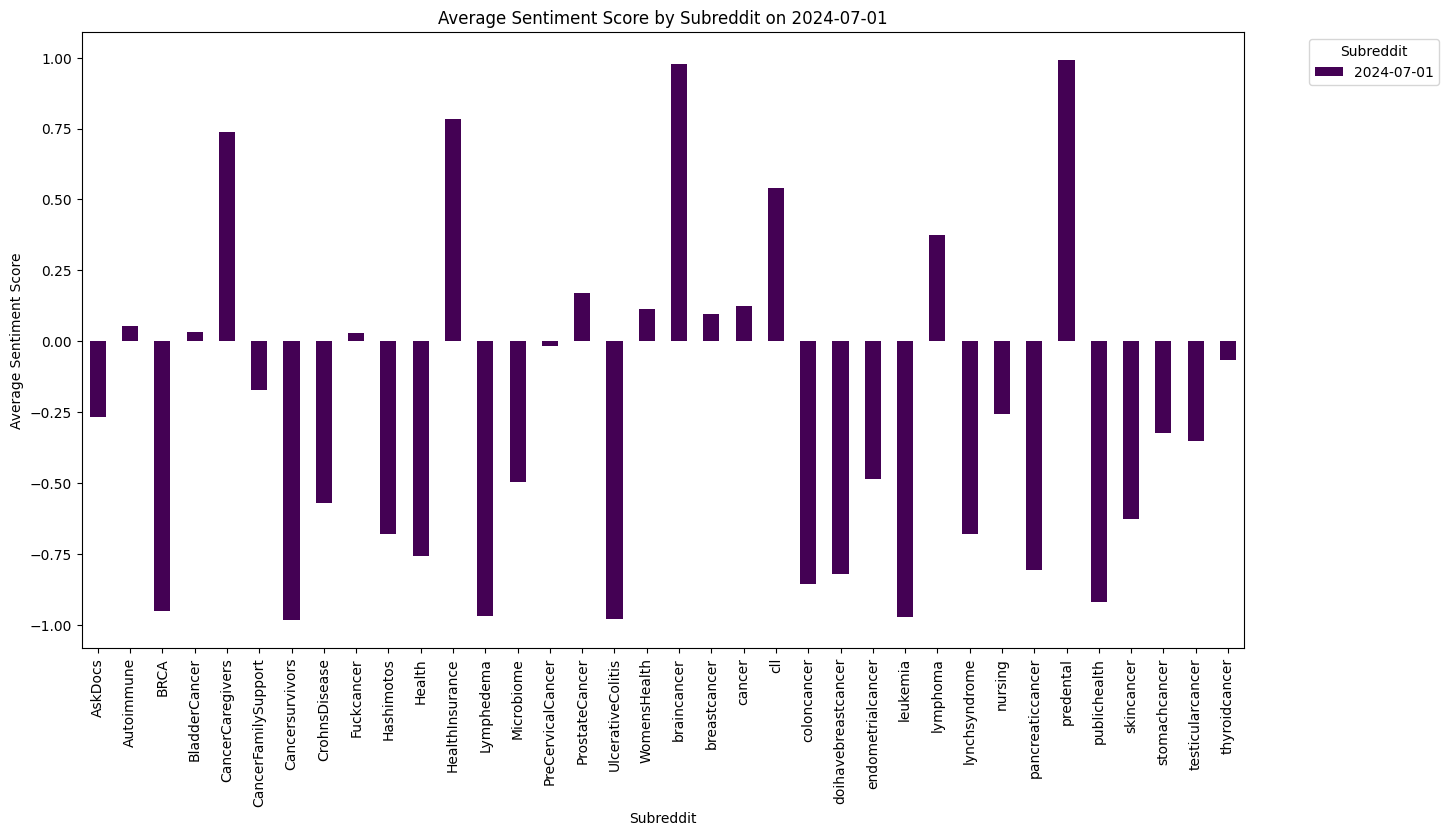

In [53]:
daily_sentiment = df.groupby(['date', 'subreddit'])['sentiment_score'].mean().unstack()
plt.figure(figsize=(15, 8))
daily_sentiment.T.plot(kind='bar', figsize=(15, 8), colormap="viridis")
plt.title('Average Sentiment Score by Subreddit on {}'.format(daily_sentiment.index[0]))
plt.xlabel('Subreddit')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.legend(title="Subreddit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## How is the sentiment score distribution?

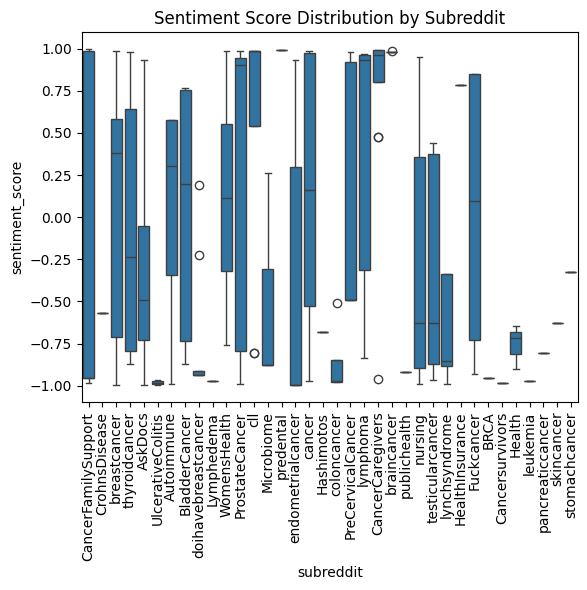

In [54]:
sns.boxplot(data=df, x='subreddit', y='sentiment_score')
plt.xticks(rotation=90)
plt.title('Sentiment Score Distribution by Subreddit')
plt.show()
